<a href="https://colab.research.google.com/github/ShvetsovEgor/ML/blob/main/%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_ML_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Решение команды Саратовские вареники проектного задания в рамках весеннего МЛ интенсива Академии Яндекса 2023

#### Импортируем необходимые библиотеки

In [1]:
!pip install torchshow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import torchshow as ts
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.utils import to_categorical
print(tf.__version__)

2.12.0


#### Скачаем данные

Json файл с ключом к kaggle API можно сгенерировать и скачать по ссылке [тык](https://www.kaggle.com/alexnikko/account): **API -> create new API token**

После этого загрузите файл *kaggle.json* в колаб и выполните ячейку ниже - данные сами скачаются и распакуются

In [3]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c ml-intensive-of-yandex-academy-2023
!unzip ml-intensive-of-yandex-academy-2023.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.9/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.9/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open ml-intensive-of-yandex-academy-2023.zip, ml-intensive-of-yandex-academy-2023.zip.zip or ml-intensive-of-yandex-academy-2023.zip.ZIP.


In [7]:
!mv kaggle.json /root/.kaggle/
!kaggle competitions download -c ml-intensive-of-yandex-academy-2023
!unzip ml-intensive-of-yandex-academy-2023.zip

 95% 250M/263M [00:01<00:00, 142MB/s]
100% 263M/263M [00:01<00:00, 145MB/s]
Archive:  ml-intensive-of-yandex-academy-2023.zip
  inflating: data_test               
  inflating: data_train              
  inflating: meta                    


In [ ]:
# ЗАГРУЗКА ЛОКАЛЬНЫХ ДАННЫХ (обработка не нужна)
loaded_data = np.load('images.npz')
train_and_val_images = loaded_data['train_and_val']
train_and_val_labels = loaded_data['labels']
test_images = loaded_data['test']
val_size=0.01
train_images, validation_images, train_labels, validation_labels = train_test_split(train_and_val_labels, test_size=val_size, random_state=2,) 

In [9]:
train_and_val = pd.read_pickle('data_train')
test= pd.read_pickle('data_test')

train_and_val_images = train_and_val['images']
train_and_val_labels = train_and_val['labels']
# train_and_val_labels = np.eye(10)[train_and_val_labels]

test_images = test["images"]
print(f'Train data keys: {train_and_val.keys()}')
print(f'Test data keys: {test.keys()}\n')
print(f'Shape of train images: {train_and_val_images.shape}')
print(f'Shape of test images: {test["images"].shape}\n')
print(f'Unique labels: {set(train_and_val_labels )}\n')
print(f'Classes distribution: {pd.Series(train_and_val_labels).value_counts(normalize=True)}')

Train data keys: dict_keys(['section', 'labels', 'images'])
Test data keys: dict_keys(['section', 'images'])

Shape of train images: (50000, 32, 32, 3)
Shape of test images: (25000, 32, 32, 3)

Unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Classes distribution: 1    0.19300
2    0.15190
3    0.11250
4    0.09882
5    0.09208
7    0.07752
6    0.07718
0    0.06682
8    0.06664
9    0.06354
dtype: float64


#### Считаем данные и посмотрим какую-нибудь информацию по ним

In [10]:
from sklearn.utils import resample
data = {'id': list(range(50000)), 'labels': train_and_val_labels }
df = pd.DataFrame.from_dict(data)
# Downsampling
k = int(50000 * 0.08)
out = pd.DataFrame()
for i in range(10):
    
    res = resample(df[df["labels"] == i],
             replace=True,
             n_samples=k,
             random_state=42)
    out = pd.concat([out, res])

print(f'Classes distribution:\n{pd.Series(out.labels).value_counts(normalize=True)}')


Classes distribution:
0    0.1
1    0.1
2    0.1
3    0.1
4    0.1
5    0.1
6    0.1
7    0.1
8    0.1
9    0.1
Name: labels, dtype: float64


In [11]:
pics = []
for elem in out['id']:
  pics.append(train_and_val_images[elem])
out

,id,labels
47570,47570,0
12573,12573,0
18894,18894,0
16603,16603,0
15994,15994,0
...,...,...
40770,40770,9
24011,24011,9
49447,49447,9
48458,48458,9


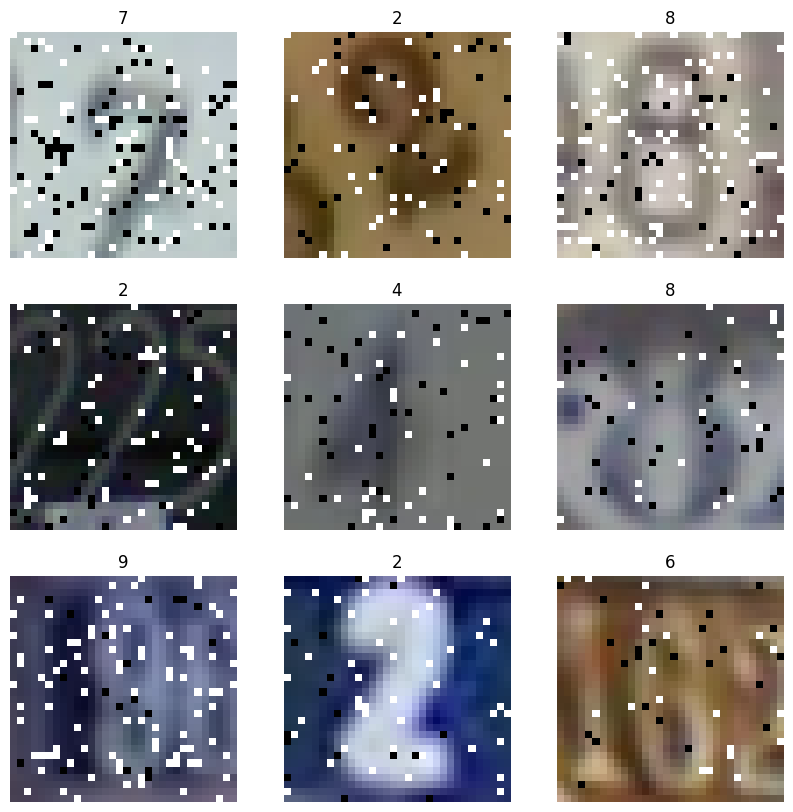

In [12]:
plt.figure(figsize=(10, 10))
for i in range(9):
    idx = np.random.randint(len(pics))
    image = np.array(pics)[idx]
    label = np.array(out['labels'])[idx]

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.astype("uint8"))
    plt.title(label)
    plt.axis("off")

In [13]:
def antinoise(image):
    for x in range(32):
        for y in range(32):
            if not(image[x][y].any()) or not((image[x][y] - np.array([255., 255., 255.])).any()):
                k = 0
                a = np.array([0., 0., 0.])
                if x > 0 and y > 0:
                    a += image[x - 1][y - 1]
                    k += 1
                if x > 0 and y < 31:
                    a += image[x - 1][y + 1]
                    k += 1
                if x < 31 and y < 31:
                    a += image[x + 1][y + 1]
                    k += 1
                if x  < 31 and y > 0:
                    a += image[x + 1][y - 1]
                    k += 1
                if x > 0:
                    a += image[x - 1][y]
                    k += 1
                if y > 0:
                    a += image[x][y - 1]
                    k += 1
                if x < 31:
                    a += image[x + 1][y]
                    k += 1
                if y < 31:
                    a += image[x][y + 1]
                    k += 1
                a //= k
                image[x][y] = a
    return image

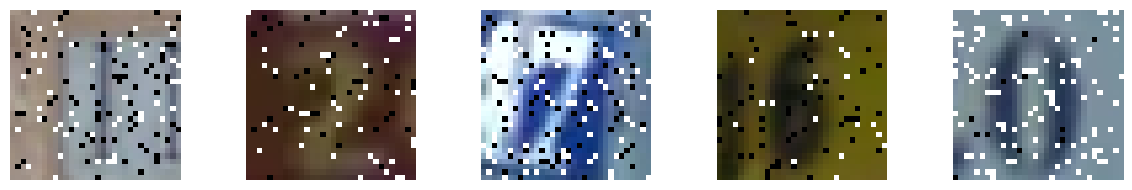

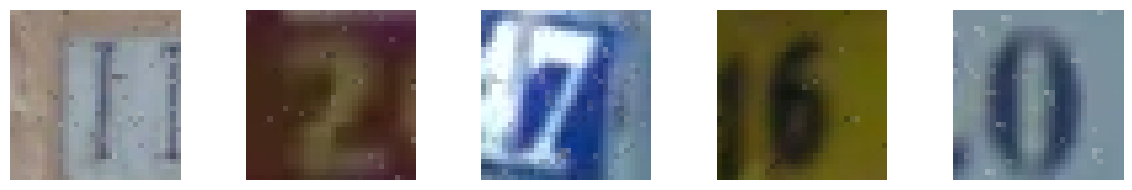

In [14]:
images = []
for i in range(5):
    idx = np.random.randint(len(pics))
    image = np.array(pics)[idx]
    images.append(image)
ts.show(images, nrows=1, figsize=(12, 2))
for elem in images:
    antinoise(elem)
ts.show(images, nrows=1, figsize=(12, 2))

In [15]:
from tqdm.notebook import tqdm
for i in tqdm(range(len(pics))):
    pics[i] = antinoise(pics[i])
for i in tqdm(range(len(test['images']))):
    test['images'][i] = antinoise(test['images'][i])

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [16]:
out['images'] = pics
out

,id,labels,images
47570,47570,0,"[[[110.0, 91.0, 94.0], [108.0, 88.0, 92.0], [1..."
12573,12573,0,"[[[51.0, 52.0, 53.0], [49.0, 50.0, 53.0], [52...."
18894,18894,0,"[[[7.0, 15.0, 18.0], [7.0, 14.0, 18.0], [5.0, ..."
16603,16603,0,"[[[106.0, 105.0, 110.0], [107.0, 106.0, 111.0]..."
15994,15994,0,"[[[126.0, 71.0, 84.0], [124.0, 70.0, 83.0], [1..."
...,...,...,...
40770,40770,9,"[[[137.0, 131.0, 119.0], [134.0, 131.0, 120.0]..."
24011,24011,9,"[[[135.0, 140.0, 134.0], [135.0, 140.0, 134.0]..."
49447,49447,9,"[[[211.0, 216.0, 212.0], [212.0, 216.0, 215.0]..."
48458,48458,9,"[[[53.0, 45.0, 107.0], [82.0, 74.0, 126.0], [1..."


Видим, что в трейне - **50к** картинок, в тесте - **25к**. 

Классов всего **10** - от 0 до 9 (цифры)

Есть дисбаланс классов: например, домов с номерами 1 **в 3 раза больше**, чем домов с номерами 9

In [17]:
val_size = 0.01

train_images, validation_images, train_labels, validation_labels = train_test_split(pics, np.array(out['labels']), test_size=val_size, random_state=2,) 
# train_images, validation_images, train_labels, validation_labels = train_test_split(train_and_val_images, train_and_val_labels , test_size=val_size, random_state=2,) 
# train_images, validation_images, train_labels, validation_labels = StratifiedKFold(n_splits=2).split(train_and_val_images, train_and_val_labels)



In [18]:
batch_size = 512

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))  ### your code here
train_dataset = train_dataset.shuffle(buffer_size=1024, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(batch_size)




In [19]:
np.savez_compressed('images.npz', train_and_val=train_and_val_images, test=test_images, labels=train_and_val_labels)


In [20]:

data_augmentation = tf.keras.Sequential([
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.2),
])
batch_size = 512
val_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
val_dataset = val_dataset.batch(batch_size)

trainDS = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
trainDS = (
    trainDS
    .batch(batch_size)
    .map(lambda x, y: (data_augmentation(x), y),num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

  



In [ ]:
# pictures = []
# labs = []
# for pic, lab in augmented_train_dataset:
#   p = pic
#   l = lab
#   if pictures == []:
#     pictures = [p[0]]
#     labs = [l[0]]
#     for i in range(1, len(p)):
#       pictures += [p[i]]
#       labs += [l[i]]
#   else:
#     for i in range(len(p)):
#       pictures += [p[i]]
#       labs += [l[i]]

Res-net


In [21]:
!pip install livelossplot
from livelossplot import PlotLossesKeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
input_shape = train_and_val_images.shape[-3:]

inputs = tf.keras.layers.Input(shape=input_shape)
rescal = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu')(rescal)
conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu')(conv1)
pooling1 = tf.keras.layers.MaxPooling2D((3, 3))(conv2)

conv3 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(pooling1)
conv4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(conv3)

added1 = tf.keras.layers.Add()([conv4, pooling1])

conv5 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(added1)
conv6 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(conv5)

added2 = tf.keras.layers.Add()([conv6, added1])

conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu')(added2)
pooling2 = tf.keras.layers.GlobalAveragePooling2D()(conv7)
dense1 = tf.keras.layers.Dense(256, activation='relu')(pooling2)
drop_out = tf.keras.layers.Dropout(0.5)(dense1)
feature = tf.keras.layers.Dense(10)(drop_out)

#res_net_cnn3 = tf.keras.Model(inputs, feature)

res_net_cnn3 = tf.keras.models.experimental.SharpnessAwareMinimization(
    tf.keras.Model(inputs, feature),
    rho=0.1
)

res_net_cnn3.compile(
    optimizer="adamax",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['sparse_categorical_accuracy']
)


In [23]:
res_net_cnn3.build((None, 32, 32, 3))
res_net_cnn3.summary()

Model: "sharpness_aware_minimization"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 10)                223242    
                                                                 
Total params: 223,242
Trainable params: 223,242
Non-trainable params: 0
_________________________________________________________________


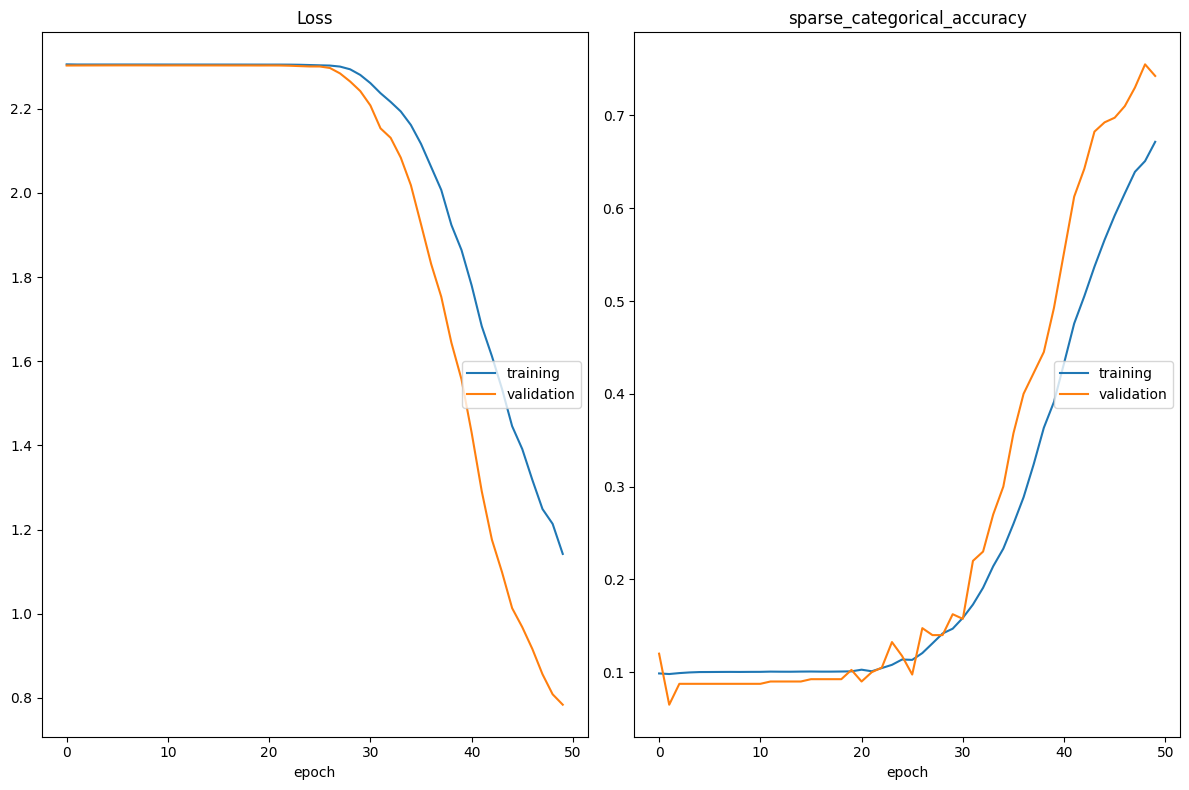

Loss
	training         	 (min:    1.142, max:    2.305, cur:    1.142)
	validation       	 (min:    0.784, max:    2.303, cur:    0.784)
sparse_categorical_accuracy
	training         	 (min:    0.098, max:    0.672, cur:    0.672)
	validation       	 (min:    0.065, max:    0.755, cur:    0.743)
78/78 [==============================] - 8s 95ms/step - loss: 1.1421 - sparse_categorical_accuracy: 0.6715 - val_loss: 0.7840 - val_sparse_categorical_accuracy: 0.7425


In [24]:
res_net_cnn3.fit(
    trainDS,
    batch_size=128,
    epochs=50,
    callbacks=[_callback, PlotLossesKeras()],
    validation_data=val_dataset,
    shuffle=True
)

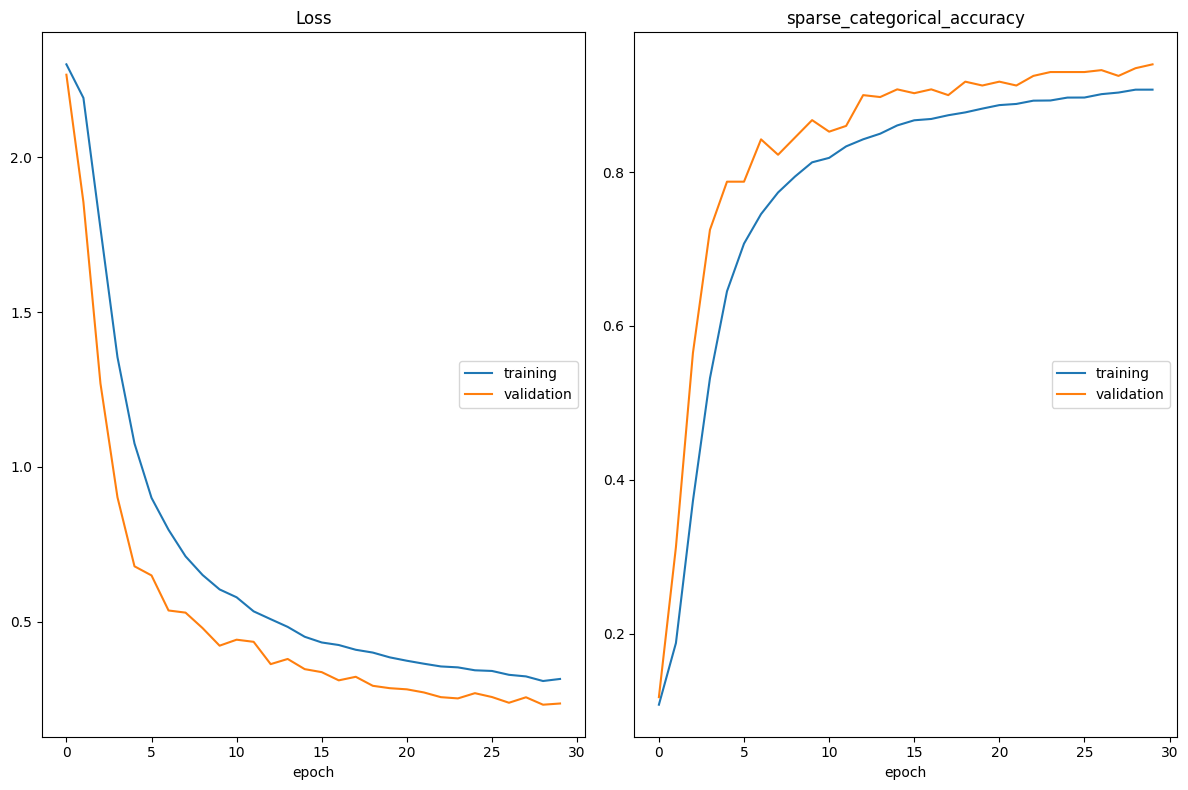

Loss
	training         	 (min:    0.308, max:    2.301, cur:    0.315)
	validation       	 (min:    0.232, max:    2.267, cur:    0.236)
sparse_categorical_accuracy
	training         	 (min:    0.108, max:    0.907, cur:    0.907)
	validation       	 (min:    0.117, max:    0.940, cur:    0.940)
78/78 [==============================] - 6s 82ms/step - loss: 0.3150 - sparse_categorical_accuracy: 0.9071 - val_loss: 0.2356 - val_sparse_categorical_accuracy: 0.9400


In [27]:
_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
input_shape =  train_and_val_images.shape[-3:]

inputs = tf.keras.layers.Input(shape=input_shape)
rescal = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu')(rescal)
conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu')(conv1)
pooling1 = tf.keras.layers.MaxPooling2D((3, 3))(conv2)

conv3 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(pooling1)
conv4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(conv3)

added1 = tf.keras.layers.Add()([conv4, pooling1])

conv5 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(added1)
conv6 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(conv5)

added2 = tf.keras.layers.Add()([conv6, added1])

conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu')(added2)
pooling2 = tf.keras.layers.GlobalAveragePooling2D()(conv7)
dense1 = tf.keras.layers.Dense(256, activation='relu')(pooling2)
drop_out = tf.keras.layers.Dropout(0.5)(dense1)
feature = tf.keras.layers.Dense(10, activation="softmax")(drop_out)

res_net_cnn2 = tf.keras.Model(inputs, feature)

res_net_cnn2.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['sparse_categorical_accuracy']
)
res_net_cnn2.fit(
    trainDS,
    batch_size=128,
    epochs=30,
    callbacks=[_callback, PlotLossesKeras()],
    validation_data=val_dataset,
    shuffle=True
)

In [28]:
preds = res_net_cnn2.predict(test['images'])
pred_labels = preds.argmax(1)
pd.DataFrame({
    'Id': range(pred_labels.size),
    'Category': pred_labels
}).to_csv('sub_res_net_cnn2.csv', index=False)

782/782 [==============================] - 2s 2ms/step


U-net

In [29]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential

In [35]:
class U_net:
    def convolution_operation(self, entered_input, filters=64):
        # Taking first input and implementing the first conv block
        conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
        batch_norm1 = BatchNormalization()(conv1)
        act1 = ReLU()(batch_norm1)
        
        # Taking first input and implementing the second conv block
        conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
        batch_norm2 = BatchNormalization()(conv2)
        act2 = ReLU()(batch_norm2)
        
        return act2
    def encoder(self, entered_input, filters=64):
        # Collect the start and end of each sub-block for normal pass and skip connections
        enc1 = self.convolution_operation(entered_input, filters)
        MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
        return enc1, MaxPool1
    def decoder(self, entered_input, skip, filters=64):
        # Upsampling and concatenating the essential features
        Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
        Connect_Skip = Concatenate()([Upsample, skip])
        out = self.convolution_operation(Connect_Skip, filters)
        return out

    def build(self, Image_Size):
        # Take the image size and shape
        input1 = Input(Image_Size)
        
        # Construct the encoder blocks
        skip1, encoder_1 = self.encoder(input1, 16)
        skip2, encoder_2 = self.encoder(encoder_1, 16*2)
        skip3, encoder_3 = self.encoder(encoder_2, 16*4)
        skip4, encoder_4 = self.encoder(encoder_3, 16*8)
        
        # Preparing the next block
        conv_block = self.convolution_operation(encoder_4, 16*16)
       
        # Construct the decoder blocks
        decoder_1 = self.decoder(conv_block, skip4, 16*8)
        decoder_2 = self.decoder(decoder_1, skip3, 16*4)
        decoder_3 = self.decoder(decoder_2, skip2, 16*2)
        decoder_4 = self.decoder(decoder_3, skip1, 16)
        
        # out = Conv2D(1, 1, padding="same", activation="softmax")(decoder_4)
        outputs = tf.keras.layers.Dense(10, activation='softmax')(decoder_4)
        outputs = tf.keras.layers.Flatten()(outputs)
        model = Model(input1, outputs)
        return model
input_shape = (32, 32, 3)
u_net = U_net().build(input_shape)


# tf.keras.utils.plot_model(u_net, "model.png", show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [36]:
u_net.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_39 (Conv2D)             (None, 32, 32, 16)   448         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_18 (BatchN  (None, 32, 32, 16)  64          ['conv2d_39[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_18 (ReLU)                (None, 32, 32, 16)   0           ['batch_normalization_18[0]

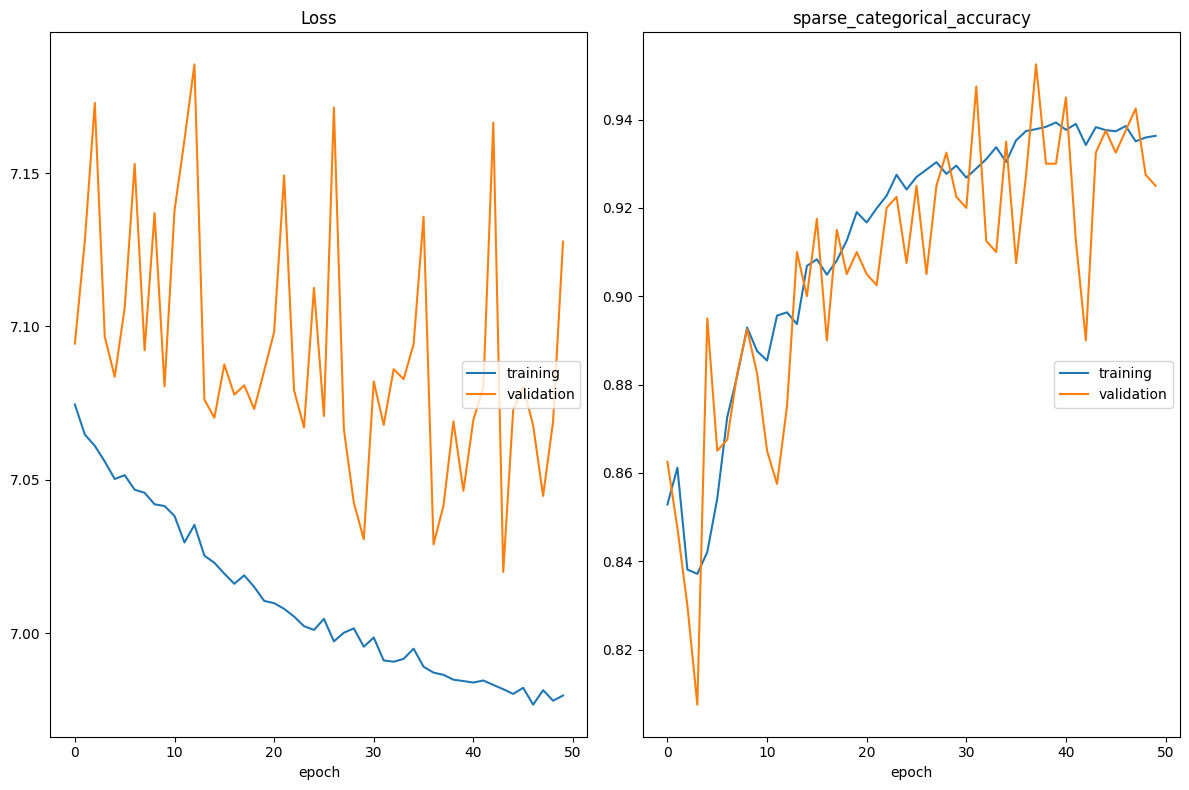

Loss
	training         	 (min:    6.977, max:    7.075, cur:    6.980)
	validation       	 (min:    7.020, max:    7.185, cur:    7.128)
sparse_categorical_accuracy
	training         	 (min:    0.837, max:    0.939, cur:    0.936)
	validation       	 (min:    0.808, max:    0.952, cur:    0.925)
78/78 [==============================] - 9s 119ms/step - loss: 6.9797 - sparse_categorical_accuracy: 0.9363 - val_loss: 7.1277 - val_sparse_categorical_accuracy: 0.9250


In [38]:
from tensorflow.keras.optimizers.legacy import Adam

optimizer = Adam()
u_net.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['sparse_categorical_accuracy']
)

u_net.fit(
    trainDS,
    batch_size=128,
    epochs=70,
    callbacks=[_callback, PlotLossesKeras()],
    validation_data=val_dataset,
    shuffle=True
)

In [34]:
preds = u_net.predict(test['images'])
pred_labels = preds.argmax(1)
pd.DataFrame({
    'Id': range(pred_labels.size),
    'Category': pred_labels
}).to_csv('sub_u_net.csv', index=False)

782/782 [==============================] - 2s 3ms/step


### VGG

In [41]:
from keras.applications import VGG16

In [49]:
input_layer=layers.Input(shape=(32, 32, 3))
model_vgg16=VGG16(weights='imagenet',input_tensor=input_layer,include_top=False)

In [53]:
last_layer = model_vgg16.output
flatten = layers.Flatten()(last_layer)
dense1 = layers.Dense(100, activation='relu')(flatten)
dense1 = layers.Dense(100, activation='relu')(flatten)
dense1 = layers.Dense(100, activation='relu')(flatten)
output_layer = layers.Dense(1, activation='softmax')(flatten)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)
for layer in model.layers[:-1]:
    layer.trainable=False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

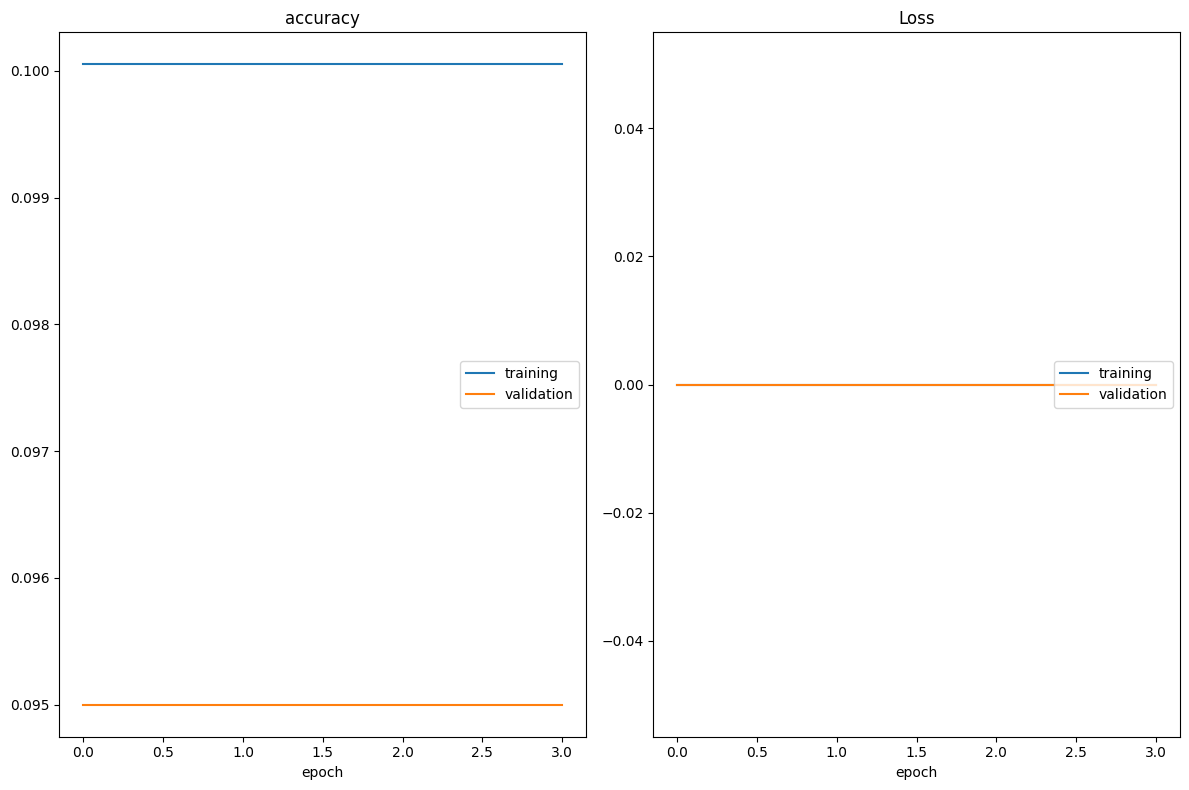

accuracy
	training         	 (min:    0.100, max:    0.100, cur:    0.100)
	validation       	 (min:    0.095, max:    0.095, cur:    0.095)
Loss
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
78/78 [==============================] - 8s 107ms/step - loss: 0.0000e+00 - accuracy: 0.1001 - val_loss: 0.0000e+00 - val_accuracy: 0.0950


In [56]:
model.fit(
    trainDS,
    batch_size=128,
    epochs=70,
    callbacks=[_callback, PlotLossesKeras()],
    validation_data=val_dataset,
    shuffle=True
)

#### Создадим простую модель

В качестве нейронной сети возьмем просто перцептрон, то есть двуслойную нейросеть (с двумя линейными слоями)

Во-первых, нам необходимо отмасштабировать картинки из целочисленного диапазона от 0 до 255 (значения пикселей) в вещественный диапазон от 0 до 1. За это будет отвечать слой **Rescaling**.

Во-вторых, нужно "распрямить" картинку. На вход нейронной сети подается трехканальное изображение (RGB) с высотой и шириной равными 32. Таким образом необходимо из размерности 32x32x3 сделать вектор размерности 32*32*3. За это отвечает слой **Flatten**.

Дальше схема простая: x -> Linear -> Relu -> Linear

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1.0 / 255),
   tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10)])

#### Зададим оптимизатор, функцию потерь и метрики

В качестве оптимизатора возьмем **RMSprop** с параметрами по умолчанию

В качестве функции потерь нам необходимо использовать **Crossentropy** (стандартный лосс для задач классификации)

В качетсве метрик, который будем считать будем использовать accuracy - целевая метрика нашего соревнования

In [ ]:
model.compile(
    optimizer="sgd",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['sparse_categorical_accuracy']
)

In [ ]:
sam = tf.keras.models.experimental.SharpnessAwareMinimization(
    model, rho=0.05, num_batch_splits=None, name=None
)
sam.fit(
    x=train_data['images'],
    y=train_data['labels'],
    batch_size=32,
    epochs=50,
    callbacks=[callback, PlotLossesKeras()],
    validation_split=0.2,
    shuffle=True
)

#### Обучение модели

Параметры:
- x - тренировочные картинки (numpy array)
- y - тренировочные лейблы (numpy array)
- batch_size - размер батча (пакета)
- epochs - количество эпох обучения 
- validation_split - сколько процентов тренировочных данных использовать в качестве валидации (в данном случае 0.2 - это 20%)
- shuffle - перешивать данные перед началом каждой эпохи или нет

In [ ]:
!pip install livelossplot

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
from livelossplot import PlotLossesKeras

In [ ]:
model.summary()

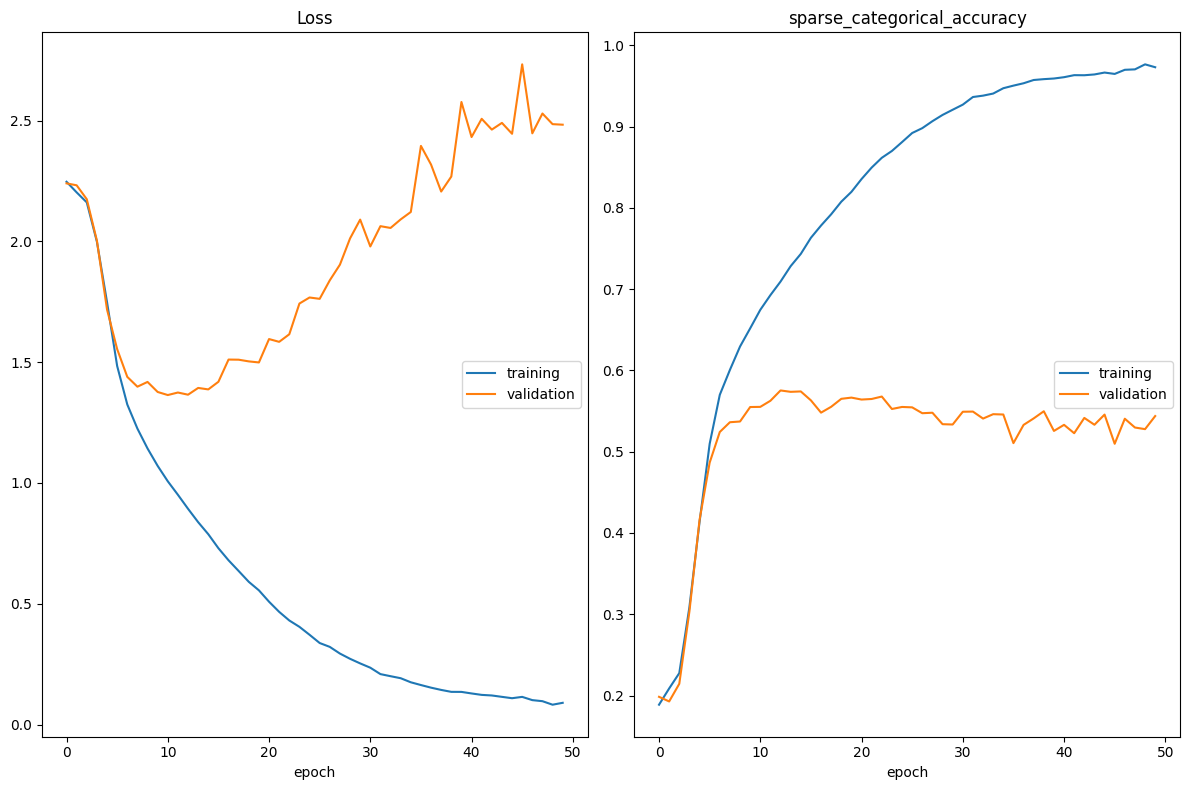

Loss
	training         	 (min:    0.082, max:    2.247, cur:    0.090)
	validation       	 (min:    1.364, max:    2.733, cur:    2.483)
sparse_categorical_accuracy
	training         	 (min:    0.189, max:    0.976, cur:    0.973)
	validation       	 (min:    0.193, max:    0.575, cur:    0.544)
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0902 - sparse_categorical_accuracy: 0.9729 - val_loss: 2.4829 - val_sparse_categorical_accuracy: 0.5438


In [ ]:
model.fit(
    x=train_data['images'],
    y=train_data['labels'],
    batch_size=32,
    epochs=50,
    callbacks=[callback, PlotLossesKeras()],
    validation_split=0.2,
    shuffle=True
)

#### Предсказание

Сделаем предсказание модели на тестовом датасете и создадим сабмит

In [ ]:
preds = model.predict(test_data['images'])
pred_labels = preds.argmax(1)
pd.DataFrame({
    'Id': range(pred_labels.size),
    'Category': pred_labels
}).to_csv('sub.csv', index=False)

NameError: ignored

#### Дальнейшие шаги

В какую сторону нужно думать, чтобы улучшить качество:

- **Модель.** Сейчас мы используем простую двуслойную нейронную сеть с линейными слоями. Однако для классификации изображений принято использовать сверточные нейронные сети. Их реализацией и стоит заняться в первую очередь.
- **Данные.** Если посмотреть на данные (картинки), то можно понять, что они не идеальны. Нужно придумать способы, как улучшить их качество. + можно использовать аугментации.
- **Схема тренировки.** В данном ноутбуке практически все параметры заданы по умолчанию, однако можно с ними поэксперементировать. Различные оптимизаторы, learning rate, schedulers - на всё это стоит обратить внимание.